# Embeddings: What Are They and When to Use Them?

## Intro

Working with non-numerical data can be a challenge for a Data Scientist. First, we have to transform this data into something that can be consumed by a Machine Learning model - which is typically a vector in $\mathbb{R}^p$. Second, if we keep all source information, dimensionality of the resulting space $p$ can be huge ($p\approx n$ or $p>n$, where $n$ is number of samples). A big number of dimensions can make data analysis or model training tough (this phenomenon is called *curse of dimensionality* for a reason). How could we obtain a numeric vector with a reasonable number of dimension? 

The answer is **embedding**.

An embedding is a low-dimensional representation of high-dimensional data. There exist many embeddings that work on particular data structures, for example:
- PCA and ICA for numerical data,
- word2vec and BERT for text data,
- Fourier descriptors for shape image data.

For example, applying Fourier descriptors to an image with a curve will produce a vector of numbers of a specified dimensionality $p$. Bigger $p$ will allow to approximate the original space better, but the most important shape structure should be captured by just a few first components.

Here, we will focus on using embeddings with data of an arbitrary nature - be it vectors, curves, graphs, words or images. Here is the only thing that we will need: we need to be able to say how similar any two samples from this data are. Using shapes as example: an oval and a circle will be more similar than an oval and triangle. In other words, we need to define *similarity* or *dissimilarity* matrix on the dataset. While a similarity matrix could be used as a numeric feature on its own its often not practical as its dimensionality is the same as the number of samples $p=n$. Using an embedding could reduce $p$ substantially while still keeping important information.

Embeddings that we will cover:
- PCA (of course!)
- Locally Linear Embedding (LLE)
- Kernel PCA
- Spectral embedding
- Multidimensional Scaling (MDS)

The list is not complete but it is not meant to be. Rather then going through every single embedding, we will focus on application of embeddings to solve real-world problems. Then you can use your own favorite linear or non-linear embedding to tackle the problem that you have.

We will also discuss pros and cons of using embeddings with similarity (or dissimilarity) matrices. Yes, incredible versatility of this method doesn't come for free. Sometimes you may be better off using a specialized embedding instead or not using embeddings at all. Alas, a Machine Learning method that is great at at absolutely everything has not been yet discovered... If it has and I missed it - do let me know =)

## Similarity and Dissimilarity matrices

Similarity and dissimilarity matrices serve a similar (pun time!) purpose: they define how similar (or dissimilar) any two objects in our data are.

**Similarity matrix** for data with $n$ samples is a $(n,n)$ matrix $S$, where element $S_{ij}$ contains similarity measure between samples $i$ and $j$.
- Higher numbers indicate similar samples.
- For example, for numerical data radial basis kernel is often used: $S_{ij}=\exp{-\frac{|x_i-x_j|^2}{2\sigma^2}}$.

**Dissimilarity matrix** is a $(n,n)$ matrix $D$, here element $S_{ij}$ contains dissimilarity measure between samples $i$ and $j$.
- It is "the opposite" of similarity matrix: lower numbers indicate similar samples.
- For numerical data, any metric could be used to create a distance matrix, which will be a dissimilarity matrix. We could also use a distance function that is not a metric (triangle inequality may not hold), which is very convenient if we deal with non-numerical data.
- We can convert any dissimilarity matrix to similarity matrix or via versa (e.g., by subtracting it from a diagonal matrix, or by computing radial kernel)

Okay, the math part is over. Let's go, it's Machine Learning time!

---
Some unnecessarily technical moments:
1. Usually, similarity and dissimilarity matrices are assumed to be positive semi-definite.
2. A kernel matrix required for Kernel PCA and SVM can be computed by applying kernel to a distance matrix. However, if a distance function is not a metric (triangle inequality does not hold), the resulting matrix will not be, strictly speaking, a kernel matrix. Everything will probably work out anyway, but it's better to keep it in mind.

# Primer on Embeddings with 2D Spatial Data

First, let's see how embedding methods work on very simple 2D data. Specifically,
- Can an embedding discover the underlying data structure and groups within the dataset?
- Will a 1D-embedding be able to reduce data dimensionality without significant information loss?

---

2D is already as low-dimensional as it gets. In reality, you probably won't need to use embeddings to deal with this kind of data - it's just useful to get some intuition of how it works.

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.manifold import SpectralEmbedding, MDS, LocallyLinearEmbedding, Isomap
from sklearn.cluster import KMeans
import sys
from loguru import logger

np.random.seed(42**3)
plt.style.use('seaborn')
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.figsize'] = (6, 3)
logger.remove()
logger.add(sys.stderr, format='{time} {level} {line}: {message}', level='DEBUG')

def gen_2d_v1(c, r1, r2, r3):
    dx, dy = r3*np.sin(r2*np.pi*2), r3*np.cos(r2*np.pi*2)
    if c == 0:
        return np.cos(r1*np.pi)+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 1:
        return np.cos(r1*np.pi)+1.2+dy, np.sin(-r1*np.pi)+0.2+dx
    elif c == 2:
        return np.cos(r1*np.pi)+2.4+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 3:
        return np.cos(r1*np.pi)+3.6+dy, np.sin(-r1*np.pi)+0.2+dx
    else:
        raise ValueError(f'Category "{c}" is not recognized')
        

def gen_2d_v2(c, r1, r2, r3):
    dx, dy = r3*np.sin(r2*np.pi*2), r3*np.cos(r2*np.pi*2)
    if c == 0:
        return np.cos(r1*np.pi)+dy, np.sin(r1*np.pi)-0.2+dx
    elif c == 1:
        return np.cos(r1*np.pi)+1.2+dy, np.sin(-r1*np.pi)+0.2+dx
    elif c == 2:
        return 1.2*np.sin(r1*np.pi*2)+4+dx, 1.2*np.cos(r1*np.pi*2)+dy
    elif c == 3:
        return 0.7*np.sin(r1*np.pi*2)+4+dx, 0.7*np.cos(r1*np.pi*2)+dy
    else:
        raise ValueError(f'Category "{c}" is not recognized')


def generate_2d_data(n, dispersion, version='v1'):
    categories=np.random.choice(range(4), size=n)
    rvs1=np.random.rand(n)
    rvs2=np.random.rand(n)
    rvs3=np.random.exponential(scale=dispersion, size=n)
    if version == 'v1':
        gen_fun = gen_2d_v1
    elif version == 'v2':
        gen_fun = gen_2d_v2
    else:
        raise ValueError(f'Version "{version}" is not recognized')
    x, y = zip(*(gen_fun(c, r1, r2, r3) for c, r1, r2, r3 in zip(categories, rvs1, rvs2, rvs3)))
    df = pd.DataFrame(dict(
        cat=categories,
        x=x,
        y=y,
    ))
    return df

colormap = {0: 'magenta', 1: 'pink', 2: 'navy', 3: 'blue'}

def plot_2d_data(data, ax, title=None):
    ax.scatter(data['x'], data['y'], color=data['cat'].map(colormap), alpha=0.6, s=16)
    if title is not None:
        ax.set_title(title)
    
def plot_2d_data_embedding(data, embedding_obj, title, ax):
    X_ = embedding_obj.fit_transform(data[['x', 'y']])
    X_ = pd.DataFrame(X_, index=data.index, columns=[str(c) for c in range(X_.shape[1])])
    if X_.shape[1] == 1:
        X_['1'] = 0
    ax.scatter(X_['0'], X_['1'], color=data['cat'].map(colormap), alpha=0.6, s=16)
    ax.set_title(f'2D spatial data embedding: {title}')
#     X_.plot(
#         kind='scatter', x='0', y='1', alpha=0.5, color=data['cat'].map(colormap), ax=ax,
#         title=f'2D spatial data embedding: {title}'
#     )

def plot_2d_data_embedding_all(data_list, embedding_obj, title):
    n = len(data_list)
    fig, ax = plt.subplots(n, 3, figsize=(n*3, 10), sharey=True)
    fig.set_tight_layout(True)
    for i, data in enumerate(data_list):
        plot_2d_data(data, ax=ax[i, 0], title='2D spatial data')
        embedding_obj.set_params(n_components=1)
        plot_2d_data_embedding(data, embedding_obj, title + ' (1)', ax=ax[i, 1])
        embedding_obj.set_params(n_components=2)
        plot_2d_data_embedding(data, embedding_obj, title + ' (2)', ax=ax[i, 2])

## 2D spacial dataset

I've generated four 2D datasets with 4 distinct groups in each:
- dataset with four arcs,
- dataset with two arcs and two circles,
- noisy versions of the datasets above.

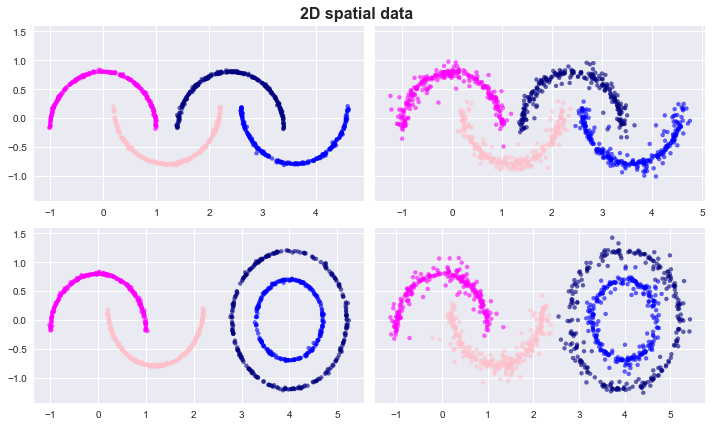

In [2]:
data_v1_simple = generate_2d_data(1000, dispersion=0.01, version='v1')
data_v1_hard = generate_2d_data(1000, dispersion=0.08, version='v1')
data_v2_simple = generate_2d_data(1000, dispersion=0.01, version='v2')
data_v2_hard = generate_2d_data(1000, dispersion=0.08, version='v2')
data_all=[data_v1_simple, data_v1_hard, data_v2_simple, data_v2_hard]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey=True)
plot_2d_data(data_v1_simple, ax=ax[0, 0])
plot_2d_data(data_v1_hard, ax=ax[0, 1])
plot_2d_data(data_v2_simple, ax=ax[1, 0])
plot_2d_data(data_v2_hard, ax=ax[1, 1])
fig.suptitle(f'2D spatial data', fontsize=16, fontweight="bold")
fig.tight_layout(rect=[0,0,1,0.96])
_=_

## Embeddings

Let's see how embeddings work on these four datasets. For each embeddings, I set the output number of dimensions to 1 or 2 (the initial number of dementions is 2).

### PCA

**Idea:** Find a linear transformation of features that maximizes captured variance of features; or, equivalently, minimizes quadratic reconstruction error. 

More precisely, let features be a sample matrix $\textbf{X} \in \mathbb{R}^{n \times p}$ have $n$ features and $p$ dimensions. For simplicity, let's assume that sample mean is zero. We can reduce the number of dimensions from $p$ to $q$ by multiplying it by an orthonormal matrix $\textbf{V}_q \in \mathbb{R}^{p \times q}$:

$$\hat{\textbf{X}} = \textbf{X} \textbf{V}_q$$

The new set of features $\hat{\textbf{X}} \in \mathbb{R}^{n \times q}$. To map the new features back to the original space (which is called *reconstruction*), we simply need to multiply it again by $\textbf{V}_q^T$. Now, we are to find the matrix $\textbf{V}_q$ that minimizes quadratic *reconstruction error*:

$$\min_{\textbf{V}_q} ||\textbf{X}\textbf{V}_q\textbf{V}_q^T - \textbf{X}||^2$$

Columns of matrix $\textbf{V}_q$ are called *principal component directions*, and columns of $\hat{\textbf{X}}$ are called *principal components*.

One of the most popular numerical methods to do it is by applying SVD-decomposition to $\textbf{X}$, but there are other equally valid ways.

**Pros:**
- It is linear, so it's quite robust to noise in data.

**Cons:**
- It only captures linear structures, so it might not always have enough flexibility.

Wall time: 675 ms


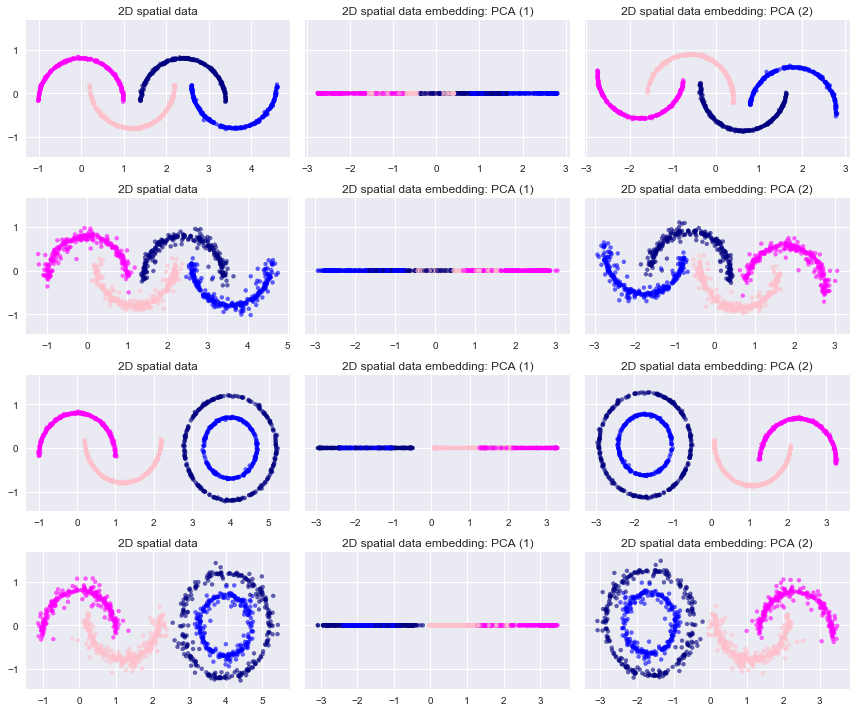

In [3]:
%%time
plot_2d_data_embedding_all(data_all, PCA(), 'PCA')

### Locally Linear Embedding (LLE)

**Idea:** Find a transformation of features that preserves local affine structure.

For each features sample $x_i \in \mathbb{R}^{p}$, $i \in \{1,..,n\}$, we approximate it by a linear combination of its $k$ nearest neighbors: 

$$\min_{w_{ik}} ||x_i - \sum_{k \in N(i)} \omega_{ik} x_k||^2$$

Then we find new features samples $z_i \in \mathbb{R}^{q}$, $i \in \{1,..,n\}$, that have a close local affine structure:

$$\min_{z_i} ||z_i - \sum_{k \in N(i)} \omega_{ik} z_i||^2$$

In `scikit-learn`, the number of nearest neighbors $k$ is set by parameter `n_neighbors`.

**Pros:**
- It captures locally linear structures but globally it's non-linear, so it's more flexible than PCA.

**Cons:**
- As it's non-linear, it is sensitive to noise in data.

Wall time: 2.64 s


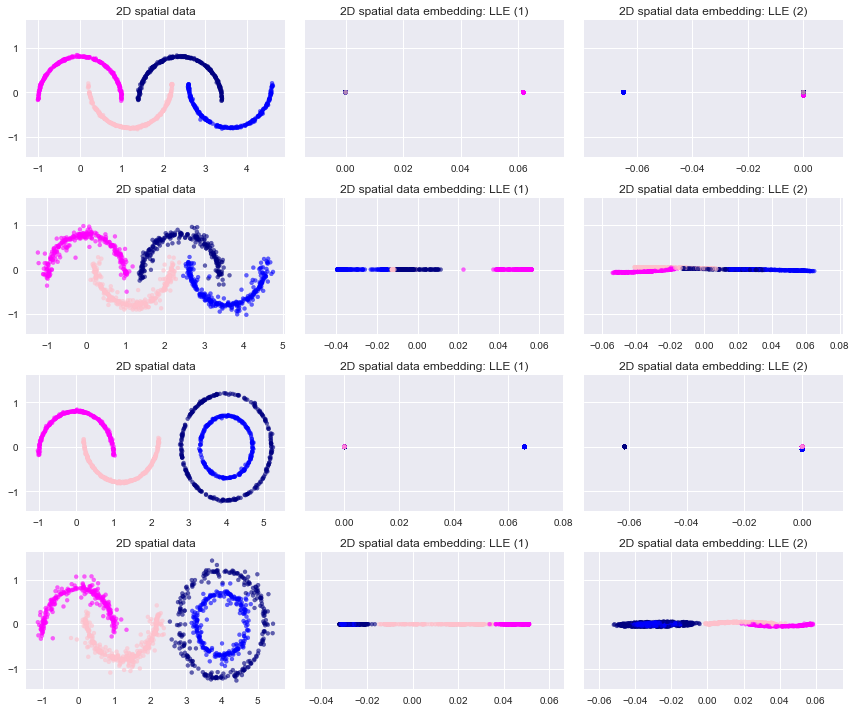

In [4]:
%%time
plot_2d_data_embedding_all(data_all, LocallyLinearEmbedding(n_neighbors=10, method='modified'), 'LLE')

### Kernel PCA

**Idea:** Apply a variation of PCA to kernel matrix.

As mentioned before, there are multiple ways to compute PCA. One of them is to compute eigen-decomposition of the empirical covariance matrix $\textbf{X}^T \textbf{X} \in \mathbb{R}^{p \times p}$. It is also possible to do it using the gram matrix $\textbf{X} \textbf{X}^T \in \mathbb{R}^{n \times n}$. Kernel PCA treats a kernel matrix of features $\textbf{K} \in \mathbb{R}^{n \times n}$ as the gram matrix in order to find principal components.

You might have heard of a kernel matrix if you're familiar with Support Vector Machines (SVM). Kernel matrix is defined by a kernel function $K(x_i,x_j)=\langle \phi(x_i),\phi(x_j) \rangle$. A popular choice is radial kernel:

$$K(x_i,x_j)=\exp -\gamma \cdot d(x_i,x_j)$$

where $d$ is a distance function. E.g., for numerical features Euclidean distance $d(x_i,x_j)=||x_i-x_j||^2$ can be used.

In `scikit-learn`, kernel function is specified with parameter `kernel`. To choose a radial kernel, set `kernel='rbf'`; $\gamma$ is set by parameter `gamma`. If kernel matrix is computed manually, set `kernel='precomputed'`.

**Pros:**
- It can capture non-linear structures.
- It is designed to work with kernel matrices. If only distance (dissimilarity) matrix is available, we can simply apply kernel function to get a kernel matrix.

**Cons:**
- The choice of distance and kernel function may greatly affect the results.

Wall time: 1.35 s


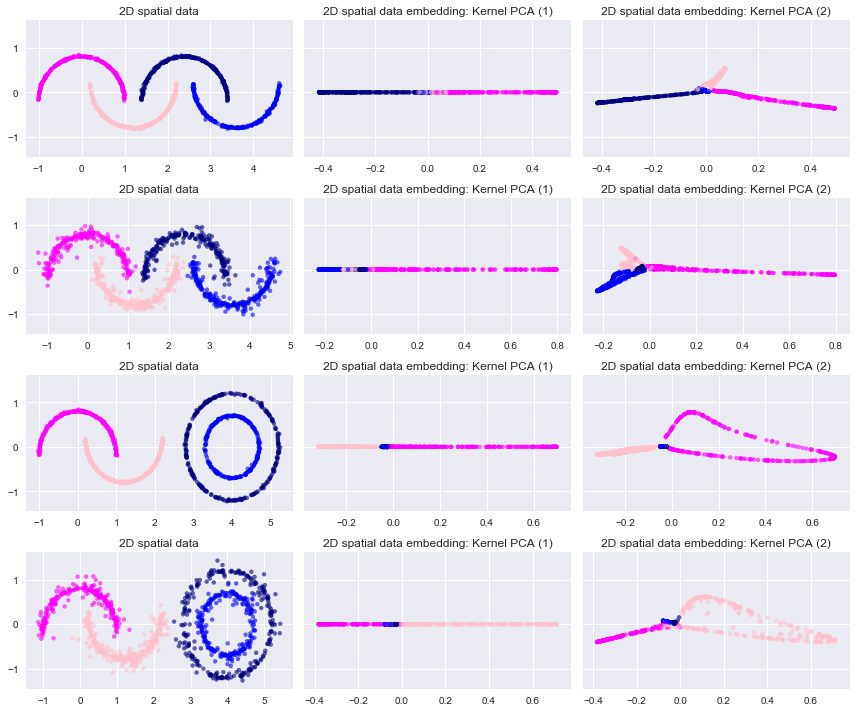

In [5]:
%%time
# high gamma => smaller local neighberhoods
plot_2d_data_embedding_all(data_all, KernelPCA(kernel='rbf', gamma=10), 'Kernel PCA')

### Spectral Embedding

**Idea:** Transform similarity matrix to similarity graph.

First, we need to transform a similarity matrix $\textbf{S} \in \mathbb{R}^{n \times n}$ to a matrix of graph edge weights $\textbf{W} \in \mathbb{R}^{n \times n}$. For example, we could obtain a fully-connected graph by using $\textbf{S}$ as $\textbf{W}$. Alternatively, we could set graph edge weight between two samples $\omega_{ij}$ to zero if they do not belong to $k$ mutual nearest neighbors, and to their similarity $s_{ij}$ otherwise.

Then we need to apply eigen-decomposition to graph Laplacian $\textbf{L}=\textbf{G}-\textbf{W}$, where $\textbf{G}$ is a diagonal matrix with $g_{ii}=\sum_{j=1}^{n} \omega_{ij}$, $i \in \{1,..,n\}$, and select $q$ eigenvectors with the smallest eigenvalues.

Why does it work? For any vector $\textbf{a} \in \mathbb{R}^{n}$,

$$\textbf{a}^T \textbf{L} \textbf{a} = \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \omega_{ij}(a_i-a_j)^2$$

so a small values of $\textbf{a}^T \textbf{L} \textbf{a}$ will be achieved if pairs of close samples (which have large $\omega_{ij}$) have close $a_i$ and $a_j$ values.

**Pros:**
- It is explicitly designed to work with similarity matrix.
- It can capture non-linear structures.
- Here, it shows a pretty good separation of the four groups of points.

**Cons:**
- It is sensitive to noise in data.
- `scikit-learn` can't transform out-of-sample data (although it is possible in principle, see the link below).

---

[Out-of-Sample Extensions for LLE, Isomap,. MDS, Eigenmaps, and Spectral Clustering. Yoshua Bengio, Jean-François Paiement, Pascal Vincent.](https://papers.nips.cc/paper/2461-out-of-sample-extensions-for-lle-isomap-mds-eigenmaps-and-spectral-clustering.pdf)

d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
d:\softwarework\pythonprojects\env\ds\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connect

Wall time: 3.1 s


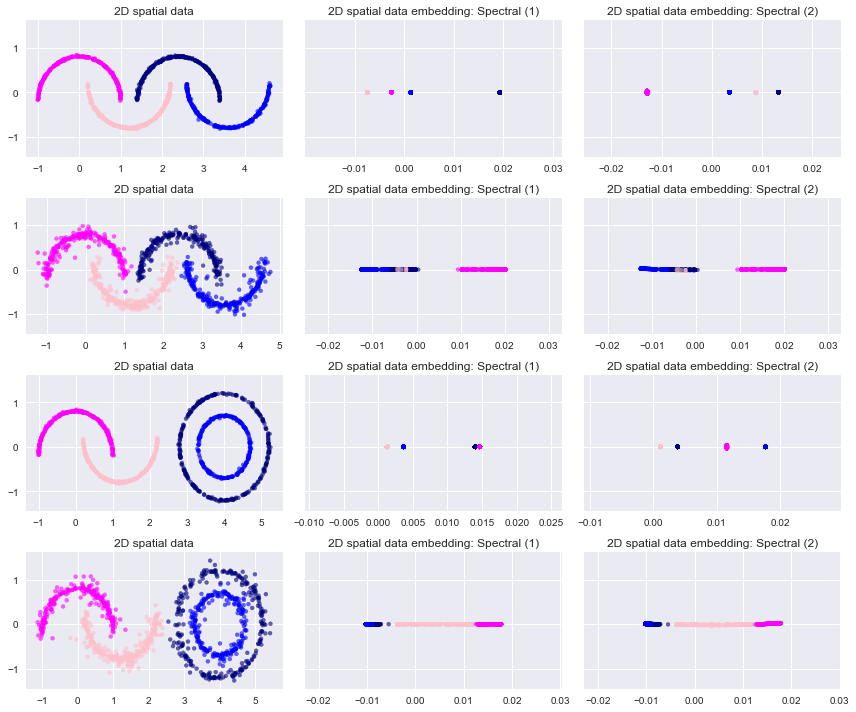

In [6]:
%%time
# high n_neighbors => larger local neighberhoods
plot_2d_data_embedding_all(data_all, SpectralEmbedding(affinity='nearest_neighbors', n_neighbors=10), 'Spectral')

### Multidimensional Scaling (MDS)

**Idea:** Find representation that preserves distances between samples globally.

MDS solves the problem of finding an appropriate low-dimensional feature representation in a very straightforward manner. Given features $x_i$, $i \in \{1,..,n\}$, we compute new features $z_i \in \mathbb{R}^{q}$, $i \in \{1,..,n\}$ by minimizing the following *stress function*:

$$\min_{z_1,..,z_n} \sum_{1 \leq i < j \leq n} (d(x_i, x_j) - ||z_i - z_j||)^2$$

where $d$ is a distance function.

There exist various modifications of this method that use different stress functions. There is also *Local MDS* modification, which replaces distance $d(x_i, x_j)$ between distant points by a constant.

**Pros:**
- It is explicitly designed to work with distance (dissimilarity) matrix.
- It preserves distances globally so it should not be much affected by noise in data.

**Cons:**
- It does not simplify separation of groups (although, it's not the goal of this method).
- This method is by far the slowest among the tested embeddings.
- Scikit-learn can't transform out-of-sample data (although it is possible in principle, see the link below).

---

[Out-of-Sample Extensions for LLE, Isomap,. MDS, Eigenmaps, and Spectral Clustering. Yoshua Bengio, Jean-François Paiement, Pascal Vincent.](https://papers.nips.cc/paper/2461-out-of-sample-extensions-for-lle-isomap-mds-eigenmaps-and-spectral-clustering.pdf)

Wall time: 1min 54s


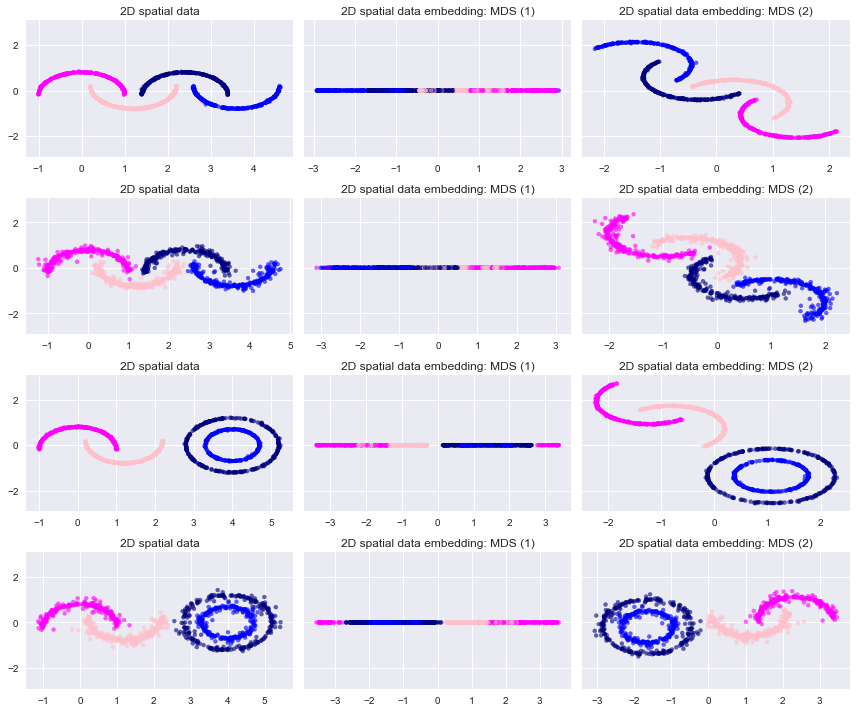

In [7]:
%%time
plot_2d_data_embedding_all(data_all, MDS(metric=True), 'MDS')

### How did we do?

Well, our only goal here was to see how embeddings work, and this is what we saw:
- Non-linear embeddings (LLE, Kernel PCA and Spectral) can be quite good at separating low-dimensional manifolds in data: useful if you need to find non-spherical clusters.
- Non-linear embeddings (LLE, Kernel PCA and Spectral) are sensitive to noise in data.
    - Takeaway: clean data first. For example, we could remove points that have less then 5 neighbours withing a certain distance.
- Linear embeddings (PCA) are quick and rubost to noisy data but may not be as efficient as non-linear embeddings on clean data.
- MDS is a good option if you like to preserve distances globally. It's also very slow so it may not be a viable option for large datasets.
- Scikit-learn does not support out-of-sample transformation for Spectral Embedding and MDS, which make them less convenient to be used for classification or regression.

**The overall message.** Different embeddings have different objectives and limitations. Choose the one that is right for your specific problem!

# Use case: Trade Routes

Let's consider the following problem: a few settlements on a small tropical island have developed trade routes. We've been tracking all package shipments on the island for some time now. We'd like to know:
- What are the main trade routes on the island?
- Can we predict the destination of a package that is currently on its route?

The data that we collected is high-dimensional: for every tracked shipment we have an ordered list of xy-coordinates where we saw the package (starting from its first and ending with its last observed locations). If we have 50 observations - we have a vector with 50 points, which is 100 dimensions (and, by the way, we cannot compare two such vectors using Euclidean metric). But if all packages are shipped through only a few routes, the effective dimensionality is probably much lower. 

Well, it sounds like just the right task for embeddings! We only need to find a way to compare two shipment routes...

---

You might ask yourself, "Is it really important that we are on a small tropical island?" And the answer is: yes, definitely! If we were on a big icy peninsula, this problem would have been solved completely differently. 

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def gen_path_curve(first, last, max_curve, step, reverse):
    n = int((last-first) / step)
    angles = np.cumsum(np.random.rand(n+1))
    angles = angles[:-1] / angles[-1]
    angles = (first + angles * (last-first))
    angles = angles * np.pi
    x = (1 - np.cos(angles)) / 2
    if reverse:
        x = 1 - x
    y = np.sin(angles) * max_curve
    return x, y

def similarity(x, y, x0, y0, x1, y1):
    l = np.sqrt((x1-x0) ** 2 + (y1-y0) ** 2)
    cos = (x1-x0) / l
    sin = (y1-y0) / l
    x_ = x0 + l * (cos * x - sin * y)
    y_ = y0 + l * (sin * x + cos * y)
    return x_, y_

def add_noise(x, y, noise_sigma):
    n = len(x)
    noise_r = np.random.normal(scale=noise_sigma, size=n)
    noise_angle = np.random.rand(n)
    x = x + noise_r*np.sin(noise_angle*np.pi*2)
    y = y + noise_r*np.cos(noise_angle*np.pi*2)
    return x, y

def gen_rand_path_curve(x0, y0, x1, y1, step, max_curve, max_curve_sigma, noise_sigma, partial_proba, reverse=False, 
                        first=0, last=1, partial_min=0.3):
    assert first < last
    if np.random.rand() < partial_proba:
        a, b = np.random.uniform(first, last-partial_min), np.random.uniform(first, last-partial_min)
        first = min(a, b)
        last = max(a, b) + partial_min
    max_curve = max_curve + np.random.normal(scale=max_curve_sigma)
    step = step / np.sqrt((x1-x0) ** 2 + (y1-y0) ** 2) / np.sqrt(1 + (2*max_curve_sigma) ** 2)
    x, y = gen_path_curve(first, last, max_curve, step, reverse)
    x, y = similarity(x, y, x0, y0, x1, y1)
    x, y = add_noise(x, y, noise_sigma)
    return x, y

def generate_path_data(n, max_curve_sigma, noise_sigma, partial_proba, partial_min=0.3, step=0.02):
    p = [1, 1, 1, 1, 1, 1, 1, 1]
    categories = np.random.choice(range(len(p)), p=p/np.sum(p), size=n)
    xy_list = []
    sigma_kwargs = dict(
        max_curve_sigma=max_curve_sigma, 
        noise_sigma=noise_sigma, 
        partial_proba=partial_proba, 
        partial_min=partial_min,
    )
    for i, cat in enumerate(categories):
        if cat == 0:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=0, y1=1, max_curve=-0.5, step=step, **sigma_kwargs)
            start, end = 0, 1
        elif cat == 1:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=0, y1=1, max_curve=-0.5, step=step, reverse=True, **sigma_kwargs)    
            start, end = 1, 0
        elif cat == 2:
            x, y = gen_rand_path_curve(x0=1, y0=0, x1=1, y1=1, max_curve=0.5, step=step, **sigma_kwargs)
            start, end = 3, 2
        elif cat == 3:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=1, max_curve=0.05, step=step, **sigma_kwargs)
            start, end = 0, 2
        elif cat == 4:
            x, y = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=1, max_curve=0.05, step=step, reverse=True, **sigma_kwargs)
            start, end = 2, 0
        elif cat == 5:
            x, y = gen_rand_path_curve(x0=1, y0=1, x1=1, y1=0, max_curve=-0.1, step=step, **sigma_kwargs)
            start, end = 2, 3
        elif cat == 6:
            x, y = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=0, max_curve=0.2, step=step, **sigma_kwargs)
            start, end = 1, 3
        elif cat == 7:
            x, y = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=0, max_curve=-0.0, step=step, **sigma_kwargs)
            start, end = 1, 3
        else:
            raise ValueError(f'Category "{cat}" is not recognized')
        xy_list.append({'cat': cat, 'xy': np.vstack((x, y)).T, 'start': start, 'end': end})
    return xy_list

colormap2 = {0: 'magenta', 1: 'darkgreen', 2: 'navy', 3: 'deepskyblue', 4: 'orange', 5: 'red', 6: 'pink', 7: 'cyan'}

def plot_path_data(path_data, title, ax, colorblind=False, annotations=True):
    for path in path_data:
        color = 'blue' if colorblind else colormap2[path['cat']] 
        ax.plot(path['xy'][:, 0], path['xy'][:, 1], alpha=0.5, color=color)
#         pd.DataFrame(path['xy'], columns=['x', 'y']).plot(
#             kind='line', x='x', y='y', alpha=0.5, color=color, ax=ax, legend=False,
#         )
        ax.set_title(f'{title} tracking data')
    if annotations:
        ax.annotate('0', (0, 0), (0.1, 0.1), size=12, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('1', (0, 1), (0.1, 1-0.1), size=12, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('2', (1, 1), (1-0.1, 1-0.1), size=12, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})
        ax.annotate('3', (1, 0), (1-0.1, 0.1), size=12, weight='bold', arrowprops={'facecolor': 'black', 'width': 1})

## Shipment data

I've generated two datasets: one rather clean and on rather noisy. Everything else is the same:
- There are 4 main points where the shipments start or end. Let's call them "trade posts" and number from 0 to 3.
- There are 6 trade routes in total, and 2 of them are bi-directional: 
    - the curved one between trade posts 0 and 1
    - the straight one between trade posts 0 and 2
- Our observations are not perfect:
    - We don't always have a full shipment path: sometimes, we only manage to track some points in the middle of the route.
    - Our observations are 100% accurate: they are usually off by relatively small distance.

In [9]:
%%time
path_data_simple = generate_path_data(
    n=200, max_curve_sigma=0.02, noise_sigma=0.01, partial_proba=0.3, step=0.02
)
path_data_hard = generate_path_data(
    n=200, max_curve_sigma=0.04, noise_sigma=0.02, partial_proba=0.7, step=0.02
)

Wall time: 50 ms


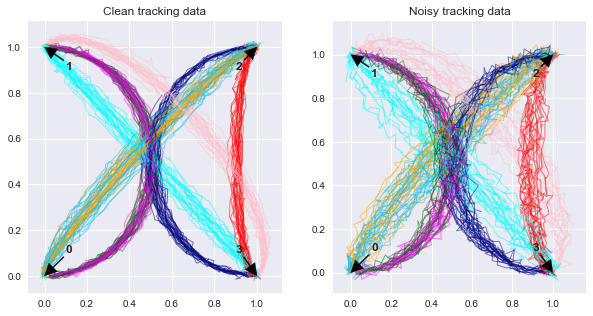

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_path_data(path_data_simple, 'Clean', ax=ax[0])
plot_path_data(path_data_hard, 'Noisy', ax=ax[1])

# How to detect main trading routes?

We have observations of numerous shipments on the island. How do we understand what the main trading routes are?

This is what we can do:
1. We choose distance measure between two paths.
2. We compute dissimilarity matrix (then similarity matrix, if necessary).
3. We apply an embedding on the matrix.

By analyzing the embedding, we can then segment the trading routes.

> Homework. Instead of analyzing embedding plots with a naked eye, use a clusterization method to separate the main trading routes. Verify how accurate the clusters are (you couldn't do it in the real world but here you "magically" know the ground truth).

You might be asking yourself, "Why do we need to detect anything? All trading routes have been nicely colored on the previous plot already." Well, true. As we generated the dataset, we happened to "magically" know all this information. But in reality, we wouldn't be that lucky. Also, if we had 100 trading posts instead of 4, analysis of data with a naked eye only would prove a little more challenging.

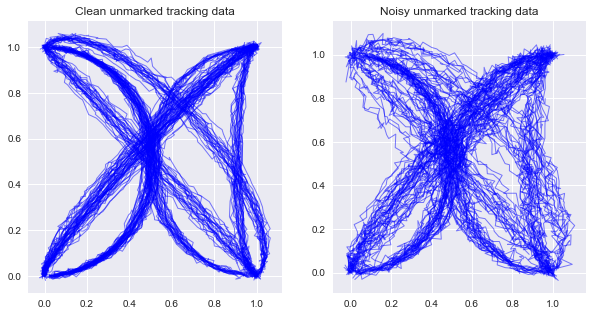

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_path_data(path_data_simple, 'Clean unmarked', ax=ax[0], colorblind=True, annotations=False)
plot_path_data(path_data_hard, 'Noisy unmarked', ax=ax[1], colorblind=True, annotations=False)

## Dissimilarity matrix

How to compute distance between two shipments? Unfortunately, is not as trivial as computing Euclidean distance between shipment route vectors. The routes may have different number of observations and different spacing between any two observations. Because of this, it's not clear how we should match the observed shipment points.

Luckily, there exists just the right distance for this case! It's called Frechet distance. From [wiki](https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance):

*Imagine a man traversing a finite curved path while walking his dog on a leash, with the dog traversing a separate one. Each can vary their speed to keep slack in the leash, but neither can move backwards. The Fréchet distance between the two curves is the length of the shortest leash sufficient for both to traverse their separate paths.*

Frechet distance is sensitive to direction of the travel. However, it's easy to modify it so it's not. Should we? Let's see:
- If we only care about trade route locations, we can ignore shipment's route direction.
- If we care who is importing to whom, we should take ship shipment's direction into account.

Also, Frechet distance is a metric, which is good as we will be using Kernel PCA and SVM.

We can see that computing dissimilarity matrix using Frechet distance can take a while, which is not too surprising: we need to compute $O(n^2)$ distances, and each distance takes $O(k^2 \log{k})$ iterations, where $n$ is the number of routes and $k$ is the number of points in a route.

Fortunately, `numba` helped to reduce computational time by quite a bit.

In [12]:
from numba import njit

@njit
def minkowski_distance_(x, y, p=2):
    return np.sum(np.abs(y-x)**p, axis=-1)**(1./p)

@njit
def frechet_dist(exp_data, num_data, p=2):
    n = len(exp_data)
    m = len(num_data)
    ca = -np.ones((n, m))
    ca[0, 0] = minkowski_distance_(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = max(ca[i-1, 0], minkowski_distance_(exp_data[i], num_data[0], p=p))
    for j in range(1, m):
        ca[0, j] = max(ca[0, j-1], minkowski_distance_(exp_data[0], num_data[j], p=p))
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = max(min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1]),
                           minkowski_distance_(exp_data[i], num_data[j], p=p))
    return ca[n-1, m-1]

path 1 - path 2 distance: 0.50
path 1 - path 3 distance: 1.00
path 1 - path 4 distance: 0.90
path 1 - path 5 distance: 1.28
Wall time: 2.56 s


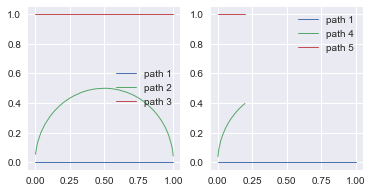

In [13]:
%%time
path1 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path2 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0.5, max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path3 = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=1, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, partial_proba=0)
path4 = gen_rand_path_curve(x0=0, y0=0, x1=1, y1=0, step=0.02, max_curve=0.5, max_curve_sigma=0, noise_sigma=0, last=0.3, partial_proba=0)
path5 = gen_rand_path_curve(x0=0, y0=1, x1=1, y1=1, step=0.02, max_curve=0., max_curve_sigma=0, noise_sigma=0, last=0.3, partial_proba=0)
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(path1[0], path1[1], label='path 1')
ax[0].plot(path2[0], path2[1], label='path 2')
ax[0].plot(path3[0], path3[1], label='path 3')
ax[0].legend()
ax[1].plot(path1[0], path1[1], label='path 1')
ax[1].plot(path4[0], path4[1], label='path 4')
ax[1].plot(path5[0], path5[1], label='path 5')
ax[1].legend()
print(f'path 1 - path 2 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path2).T):.2f}')
print(f'path 1 - path 3 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path3).T):.2f}')
print(f'path 1 - path 4 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path4).T):.2f}')
print(f'path 1 - path 5 distance: {frechet_dist(np.vstack(path1).T, np.vstack(path5).T):.2f}')

In [14]:
def compute_distance_matrix(path_data, reverse=False):
    n_samples = len(path_data)
    D = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if not reverse:
                dist = frechet_dist(path_data[i]['xy'], path_data[j]['xy'])
            else:
                dist = frechet_dist(path_data[i]['xy'], path_data[j]['xy'][::-1])
            D[i, j] = dist
            D[j, i] = dist
    return D

def compute_distance_matrix_other(path_data, path_data_other):
    m = len(path_data)
    n = len(path_data_other)
    D = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            dist = frechet_dist(path_data[i]['xy'], path_data_other[j]['xy'])
            D[i, j] = dist
    return D

def plot_path_data_embedding(D, path_data, embedding_obj, title, ax=None):
    X_ = embedding_obj.fit_transform(D)
    X_ = pd.DataFrame(X_, columns=[str(c) for c in range(X_.shape[1])])
    if X_.shape[1] == 1:
        X_['1'] = 0
    if X_.shape[1] == 2:
        ax.scatter(X_['0'], X_['1'], color=[colormap2[x['cat']] for x in path_data], alpha=0.7, s=15)
    elif X_.shape[1] == 3:
        ax.scatter(X_['0'], X_['1'], X_['2'], color=[colormap2[x['cat']] for x in path_data], s=13)
    else:
        raise ValueError(f'X_ has many dimentions: {X_.shape[1]}')
    ax.set_title(title)
    
def plot_path_data_embedding_all(D_list, path_data_list, D_name_list, embedding_obj, embedding_name):
    n = len(D_list)
    fig = plt.figure(figsize=(15, 5*n))
    fig.set_tight_layout(True)
    
    for i, D, path_data, D_name in zip(range(n), D_list, path_data_list, D_name_list):
        plot_path_data(path_data, title=f'{D_name}', ax=fig.add_subplot(n, 3, 1+i*3))
#         ax.set_title(f'{D_name}: True', fontsize=14)
        embedding_obj.set_params(n_components=2)
        plot_path_data_embedding(D, path_data_simple, embedding_obj, title=f'{D_name} data embedding: {embedding_name} (2)', 
                                 ax=fig.add_subplot(n, 3, 2+i*3))
#         ax.set_title(f'{D_name}: {embedding_name}', fontsize=14)
        embedding_obj.set_params(n_components=3)
        plot_path_data_embedding(D, path_data_simple, embedding_obj, title=f'{D_name} data embedding: {embedding_name} (3)', 
                                 ax=fig.add_subplot(n, 3, 3+i*3, projection='3d'))

In [15]:
%%time
D_simple = compute_distance_matrix(path_data=path_data_simple)
D_hard = compute_distance_matrix(path_data=path_data_hard)
D_simple_rev = compute_distance_matrix(path_data=path_data_simple, reverse=True)
D_hard_rev = compute_distance_matrix(path_data=path_data_hard, reverse=True)

D_simple_bi = np.minimum(D_simple, D_simple_rev)
D_hard_bi = np.minimum(D_hard, D_hard_rev)

Wall time: 2min 24s


In [16]:
D_list = [D_simple_bi, D_simple, D_hard_bi, D_hard]
path_data_list = [path_data_simple, path_data_simple, path_data_hard, path_data_hard]
D_name_list = ['Clean (undirect)', 'Clean', 'Noisy (undirect)', 'Noisy']

## Embeddings

We can now unleash the power of embeddings to identify trading routes on the island. Do you still remember embeddings we used for 2D spatial data? Good! We will use them here as well.

For the sake of completeness, we will compute embeddings for both directional and undirectional Frechet distance.

### PCA

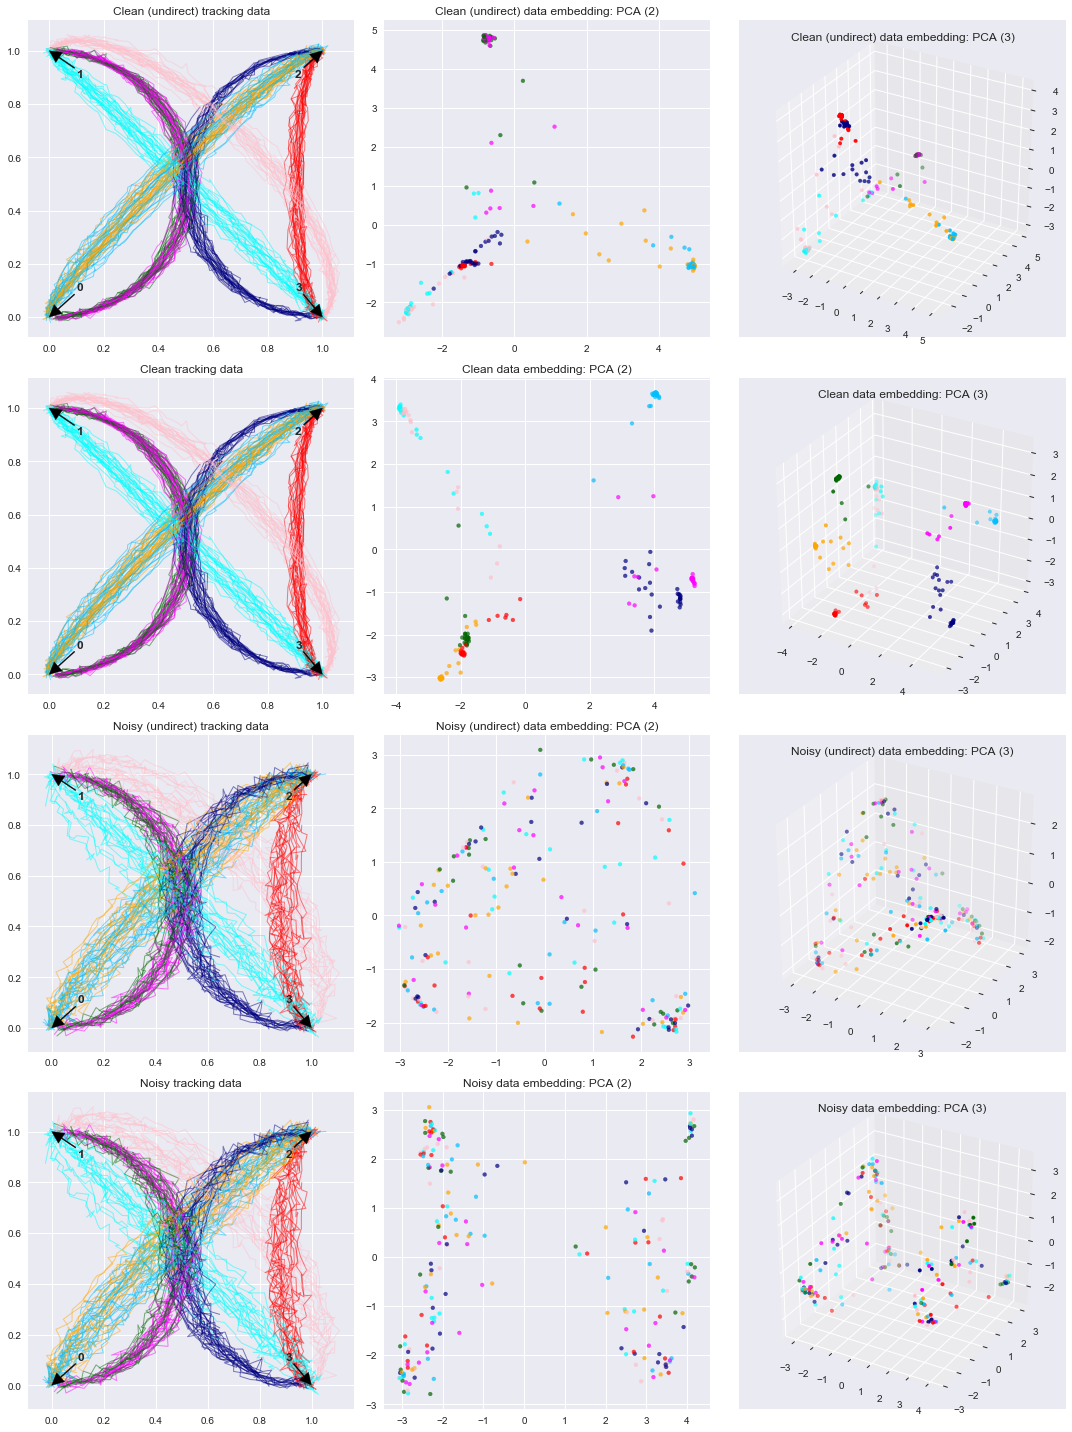

In [17]:
plot_path_data_embedding_all(
    embedding_obj=PCA(), embedding_name='PCA', 
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

### Locally Linear Embedding (LLE)

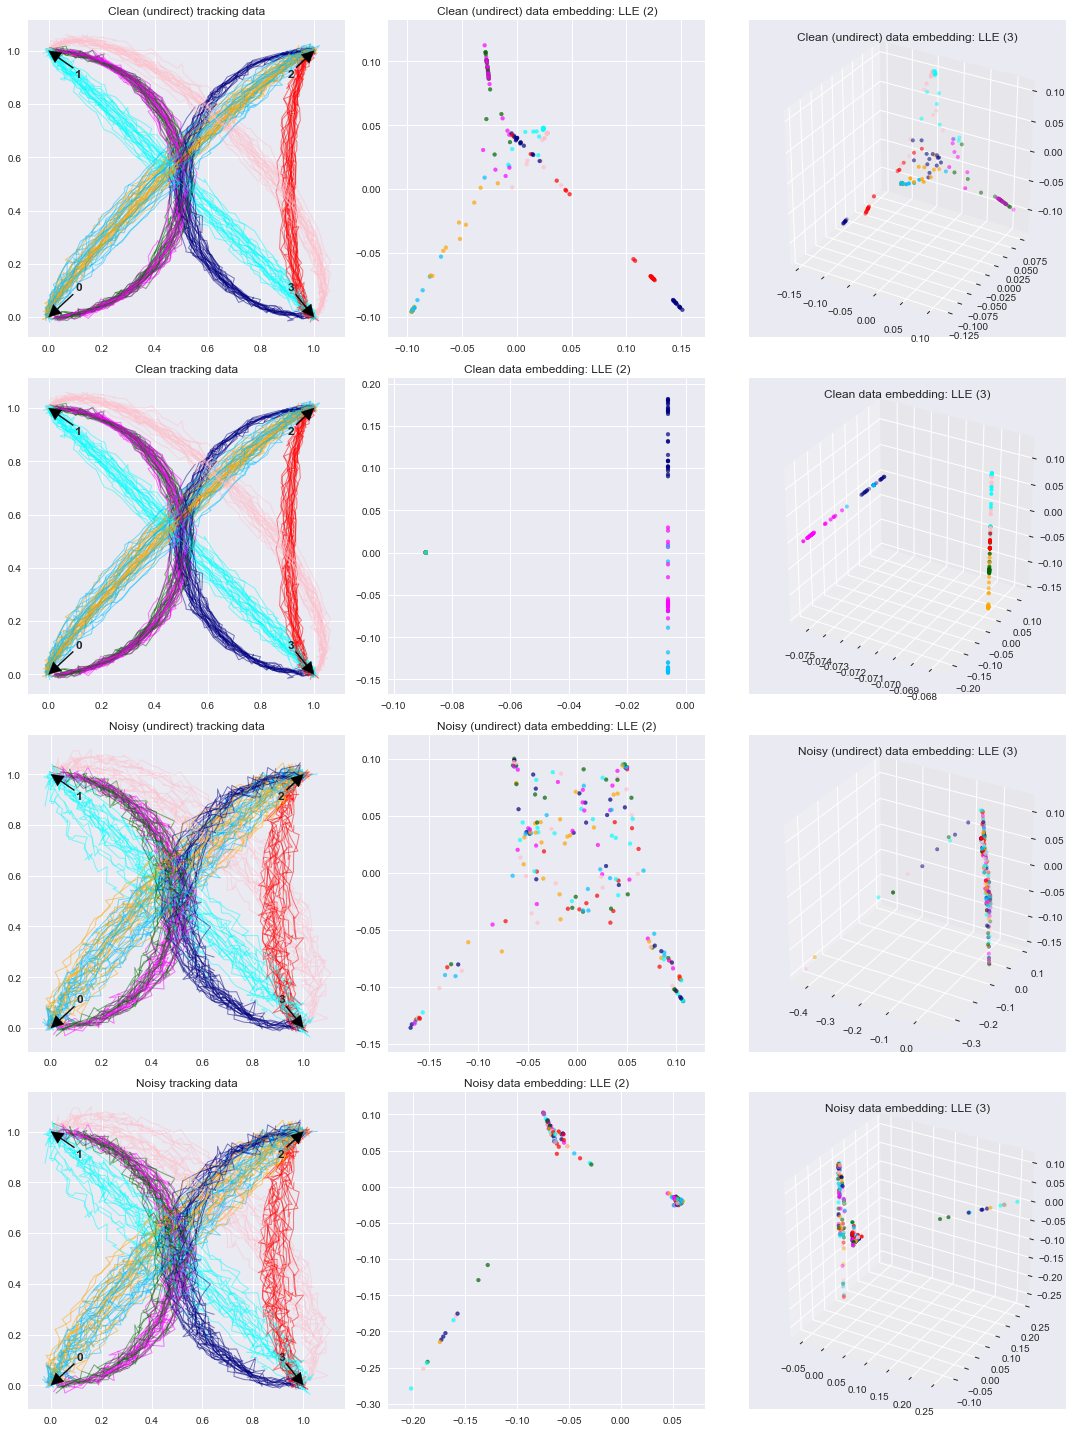

In [18]:
plot_path_data_embedding_all(
    embedding_obj=LocallyLinearEmbedding(n_neighbors=10, method='modified'), embedding_name='LLE',
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

### Kernel PCA

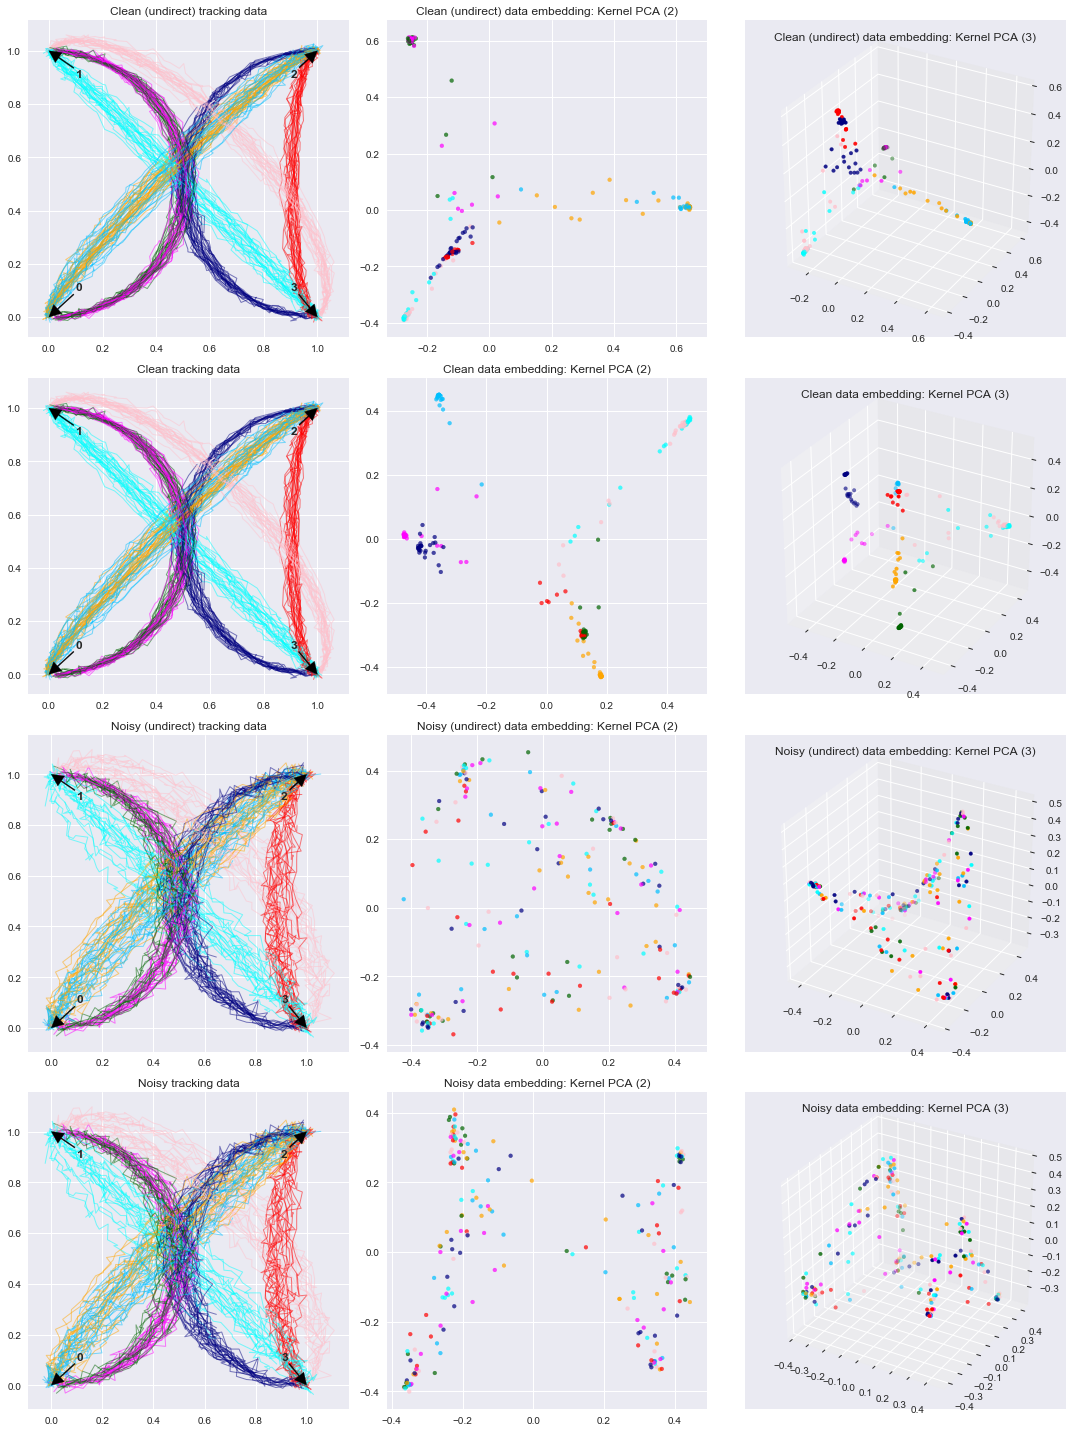

In [19]:
plot_path_data_embedding_all(
    embedding_obj=KernelPCA(kernel='precomputed'), embedding_name='Kernel PCA',
    D_list=[np.exp(-x*1.) for x in D_list], path_data_list=path_data_list, D_name_list=D_name_list
)

### Spectral Embedding

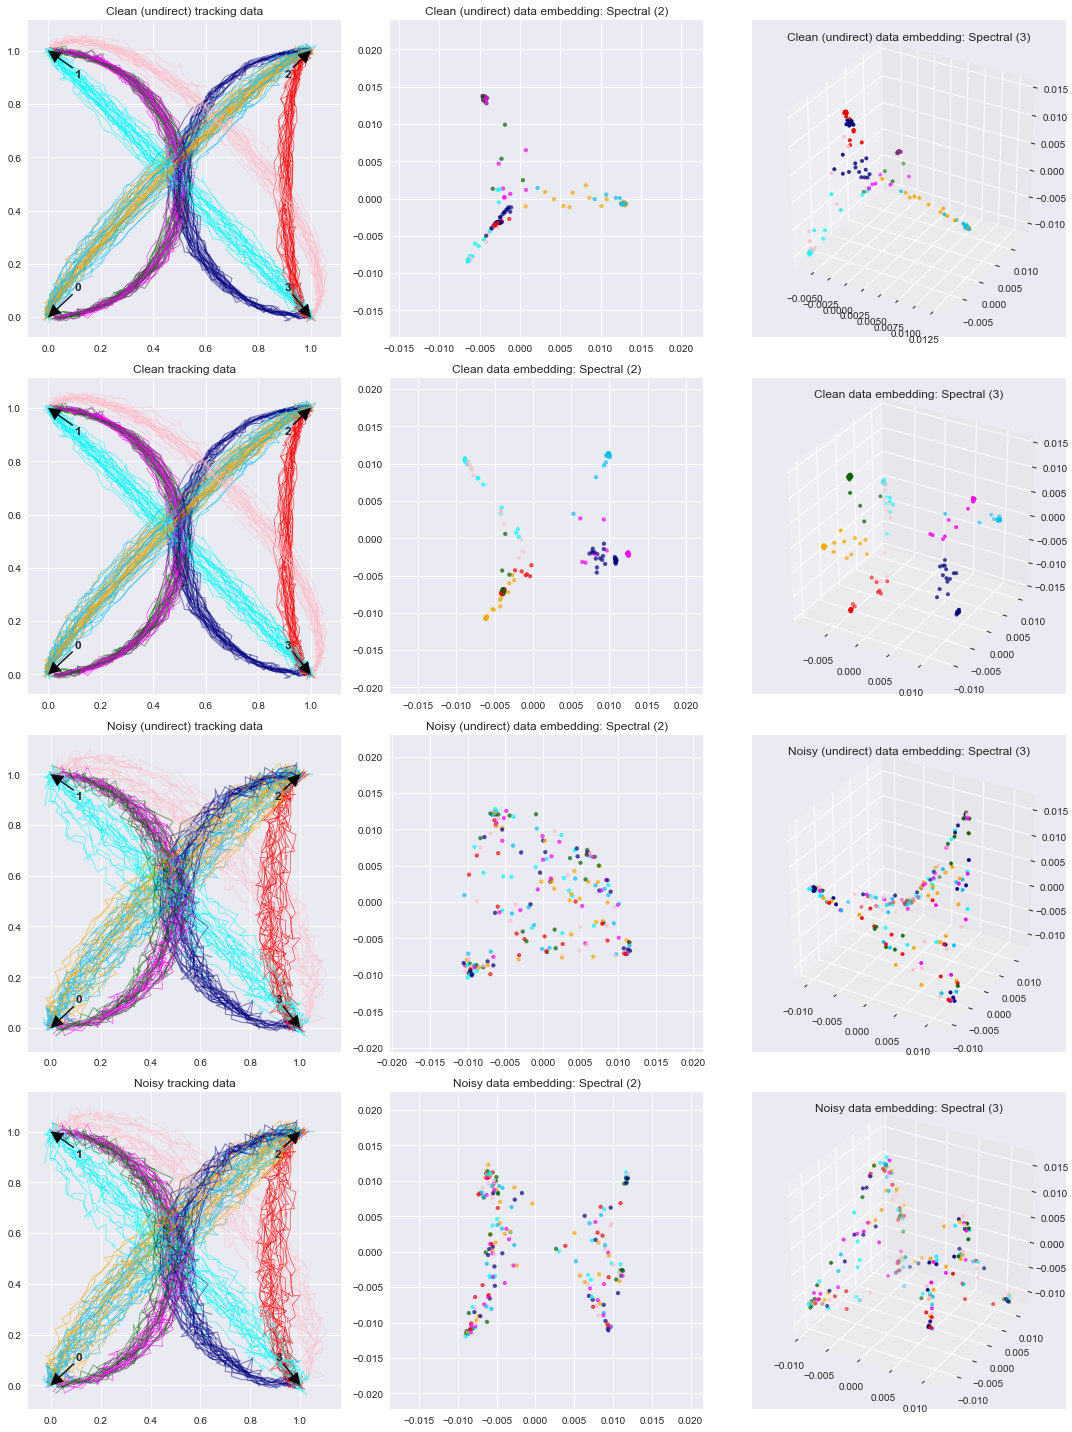

In [20]:
plot_path_data_embedding_all(
    embedding_obj=SpectralEmbedding(affinity='precomputed', n_neighbors=10), embedding_name='Spectral',
    D_list=[np.exp(-x*1.) for x in D_list], path_data_list=path_data_list, D_name_list=D_name_list
)

### Multidimensional Scaling (MDS)

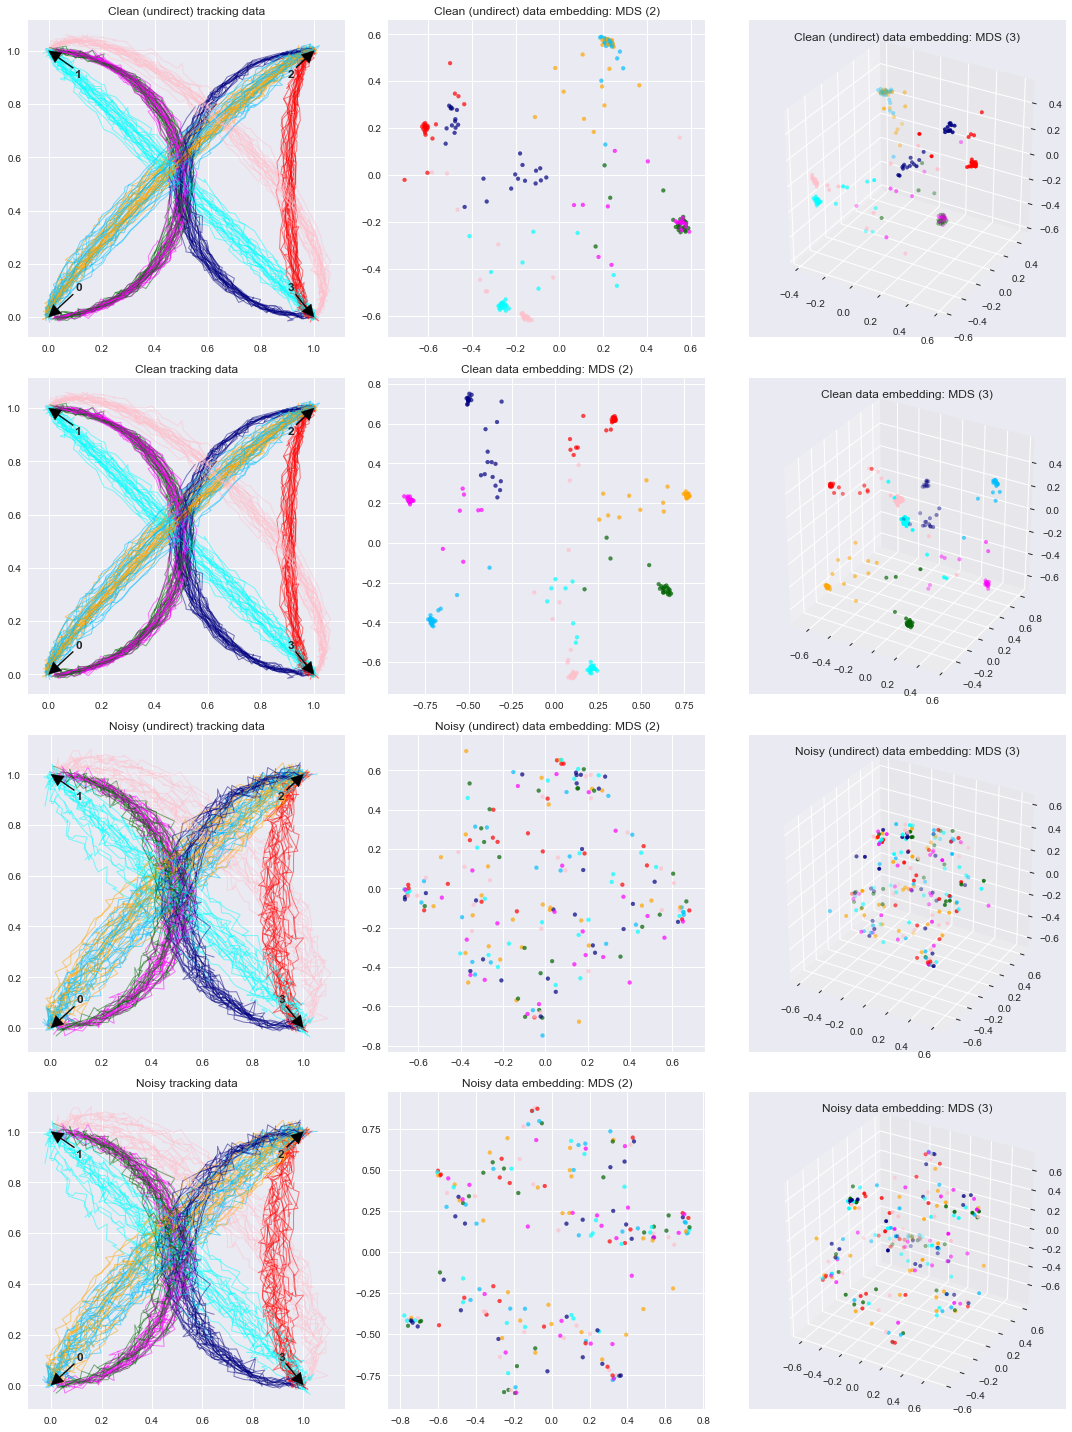

In [21]:
plot_path_data_embedding_all(
    embedding_obj=MDS(dissimilarity='precomputed'), embedding_name='MDS',
    D_list=D_list, path_data_list=path_data_list, D_name_list=D_name_list
)

## How did we do?

Dis we manage to identify all trading routes? Let's see:
- On the cleaner dataset, some embeddings did a bit better than others, but overall it is a success:
    - We can identify 6 main trade routes.
    - We can identify 8 main trade directions, which means that two trade routes serve for both import and export.
    - Interestingly, embeddings that are not designed to work with dissimilarity matrices (PCA and LLE) did well too.
- On the noisier dataset, all embeddings did rather poorly: embedding don't show clear patterns that we'd like to see in data.
    - Takeaway: Clean your data first. Here, we could remove partial paths - paths that start or end outside of any known city.
- 3D embeddings worked better than 2D.
    - Takeaway: Too many dimensions may add noise and obscure patterns in the data but too few may not be able to represent data well. Find the balance.
- Computation of dissimilarity matrix has quadratic complexity over the number of samples and can be quite slow. 
    - Takeaway: This is just something to keep in mind. And if you can optimize your distance function, it will help a lot.

# How to predict where a package is going?

Say, we used information about the trade routes to narrow area of attention for our surveillance system, so we can track every shipment from the very beginning to the very end. Now, we would like to be able to predict the package final destination when it's still on the way. How could we proceed? 

A simple approach would be:
1. Randomly split our data in two parts: train and test.
2. Fit a model on the train dataset.
    - For each shipment, drop points of the second half of the route (i.e., only keep information available by the time we want to make a prediction).
    - Compute dissimilarity matrix using Frechet distance.
    - Train an embedding algorithm and transform the data (those will be our features).
    - Extract final shipment destinations (those will be our targets).
    - Fit a classification model and generate predictions.
3. Evaluate the model's performance on the test dataset. The steps are similar to the model training, except
    - Frechet distance is computed w.r.t. the train dataset.
    - There is no need to refit the embedding and classifier.

In addition, here is a perhaps ~~smarter~~ slightly more complicated approach, which is trying to leverage the fact that embedding work better with clean data:
1. Randomly split data in three parts: two for training and one for testing ("train 1", "train 2", "test").
2. The steps to train and evaluate the model are similar, except
    - Only drop points of the second half of the route for "train 2" and "test" datasets.
    - For "train 2" and "test", Frechet distance is computed w.r.t. "train 1" dataset.
    - Fit an embedding using "train 1" dataset. As the shipment path are complete, embedding should do a better job than with half-paths.
    - Fit a classification model using "train 2" dataset.

> Homework. Modify the model so it could predict where a package is being shipped at an arbitrary point, rather than only in the middle of its route. See how model accuracy varies depending on how many route points you can use for prediction.

## New clean shipment observations

The dataset is almost exactly the same as our previous "clean" dataset, with one change: we don't have partial routes anymore. Thanks to our new targeted surveillance system, all shipments are tracked from the very beginning to the very end.

Here, we generate 10 datasets in order to estimate the impact of randomness on our results. In the real world, you could use bootstrap instead.

Wall time: 680 ms


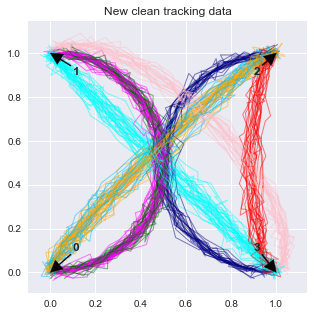

In [22]:
%%time
n_random = 10
n_samples = 200

path_data_new_list = []
for i in range(n_random):
    path_data_new_list.append(generate_path_data(n=n_samples, max_curve_sigma=0.02, noise_sigma=0.02, partial_proba=0, step=0.04))
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_path_data(path_data_new_list[0], 'New clean', ax=ax)

## Dissimilarity matrix

Here, we are computing dissimilarity matrix using "default" Frechet distance that takes direction into account. For our classification problem, it makes a lot of sense.

### Simple approach

Here, we split the dataset in two parts: train and test.

In [23]:
path_data_new_train_list = []
path_data_new_test_list = []

for i in range(n_random):
    path_data_new_train_list.append(path_data_new_list[i][:n_samples//2+1])
    path_data_new_test_list.append(path_data_new_list[i][n_samples//2+1:])

    for path in path_data_new_train_list[-1]:
        path['xy'] = path['xy'][:len(path['xy']) // 2]

    for path in path_data_new_test_list[-1]:
        path['xy'] = path['xy'][:len(path['xy']) // 2]

In [24]:
%%time
D_new_train_list = []
D_new_test_list = []

for i in range(n_random):
    D_new_train_list.append(compute_distance_matrix(path_data_new_train_list[i]))
    D_new_test_list.append(compute_distance_matrix_other(path_data_new_test_list[i], path_data_new_train_list[i]))

Wall time: 29.8 s


In [25]:
print(D_new_train_list[0].shape)
print(D_new_test_list[0].shape)

(101, 101)
(99, 101)


### "Smart" approach

Here, we split the dataset in three parts: two for training and one for testing. Dissimilarity matrices for our features - shipment paths cut in the middle - are computed w.r.t. the full shipment paths on which we will train an embedding algorithm. Sounds confusing? I know.

In [26]:
path_data_new_train_1_sm_list = []
path_data_new_train_2_sm_list = []
path_data_new_test_sm_list = []

for i in range(n_random):
    path_data_new_train_1_sm_list.append(path_data_new_list[i][:n_samples//3+2])
    path_data_new_train_2_sm_list.append(path_data_new_list[i][n_samples//3+2:2*n_samples//3+1])
    path_data_new_test_sm_list.append(path_data_new_list[i][2*n_samples//3+1:])

    for path in path_data_new_train_2_sm_list[-1]:
        path['xy'] = path['xy'][:len(path['xy']) // 2]

    for path in path_data_new_test_sm_list[-1]:
        path['xy'] = path['xy'][:len(path['xy']) // 2]

In [27]:
%%time
D_new_train_1_sm_list = []
D_new_train_2_sm_list = []
D_new_test_sm_list = []

for i in range(n_random):
    D_new_train_1_sm_list.append(compute_distance_matrix(path_data_new_train_1_sm_list[i]))
    D_new_train_2_sm_list.append(compute_distance_matrix_other(path_data_new_train_2_sm_list[i], path_data_new_train_1_sm_list[i]))
    D_new_test_sm_list.append(compute_distance_matrix_other(path_data_new_test_sm_list[i], path_data_new_train_1_sm_list[i]))

Wall time: 13 s


In [28]:
print(D_new_train_1_sm_list[0].shape)
print(D_new_train_2_sm_list[0].shape)
print(D_new_test_sm_list[0].shape)

(68, 68)
(66, 68)
(66, 68)


## Classification

Let's try several modelling methods to solve this classification problem - just to be sure that we haven't missed anything obvious:
- Distance matrix:
  - Simple approach. One train and one test dataset.
  - "Smart" approach. Two train and one test dataset. Let's see if over-engineering pays off.
- Embeddings:
  - Kernel PCA (radial kernel, 10 output dimensions). Our previous analysis showed that 3 dimensions are sufficient to separate the trade routes - let's make it 10 just to be on the safe side.
  - None. A high-dimensional distance matrix contains more information than an embedding, which could be beneficial. Or it could simply overfit the model. We shall see.
- Models:
  - Logistic Regression. Simple and robust. Classic.
  - Grading Boosting (Boosted Trees). This flexible model should be able to find whatever Logistic Regression missed.
  - Support Vector Machines. This model is designed to work with kernel matrices directly, so that's a good candidate to solve our problem.

In [29]:
from sklearn.metrics import accuracy_score

def measure_classification_accuracy(
    estimator, emb_o, 
    D_preprocess, D_train_1_l, D_train_2_l, D_test_l, 
    path_data_train_2_l, path_data_test_l
):
    accuracy_train_l = []
    accuracy_test_l = []
    ydf_l = []
    if D_train_1_l is None:
        D_train_1_l = [None for _ in range(len(D_train_2_l))]
    
    for D_train_1, D_train_2, D_test, path_data_train_2, path_data_test in zip(
        D_train_1_l, D_train_2_l, D_test_l, path_data_train_2_l, path_data_test_l
    ):
        if D_preprocess is not None:
            if D_train_1 is not None:
                D_train_1 = D_preprocess(D_train_1)
            D_train_2 = D_preprocess(D_train_2)
            D_test = D_preprocess(D_test)
        if emb_o is not None:
            emb_o.fit(D_train_1)
            X_train = emb_o.transform(D_train_2)
            X_test = emb_o.transform(D_test)
        else:
            X_train = D_train_2
            X_test = D_test
        y_train = np.array([x['end'] for x in path_data_train_2])
        y_test = np.array([x['end'] for x in path_data_test])
        estimator.fit(X_train, y_train)
        y_train_hat = estimator.predict(X_train)
        y_test_hat = estimator.predict(X_test)
        accuracy_train_l.append(accuracy_score(y_train, y_train_hat))
        accuracy_test_l.append(accuracy_score(y_test, y_test_hat))
        ydf_l.append(pd.DataFrame(dict(y=y_test, yhat=y_test_hat), dtype=str).query('y!=yhat'))
        
    pd.DataFrame(dict(
        train=accuracy_train_l,
        test=accuracy_test_l,
    )).plot(kind='box', title='Accuracy')
    print(f'accuracy (train) = {np.mean(accuracy_train_l):.3f}')
    print(f'accuracy (test) = {np.mean(accuracy_test_l):.3f}')
    ydf = pd.concat(ydf_l, axis=0)
    print((ydf['y'] + ydf['yhat']).value_counts(normalize=True).round(2).to_string())
    return accuracy_train_l, accuracy_test_l

### Direct + Kernel PCA + Logistic Regression

accuracy (train) = 0.930
accuracy (test) = 0.890
03    0.72
12    0.17
30    0.07
21    0.05
Wall time: 314 ms


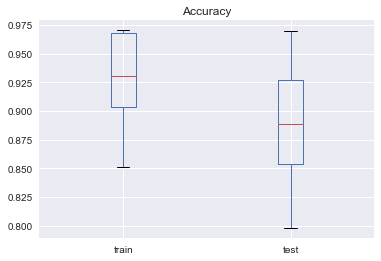

In [30]:
%%time
from sklearn.linear_model import LogisticRegression

_, direct_kpca_lr = measure_classification_accuracy(
    estimator=LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        max_iter=1000,
    ),
    emb_o=KernelPCA(kernel='precomputed', n_components=10), 
    D_preprocess=lambda x: np.exp(-x), 
    D_train_1_l=D_new_train_list, 
    D_train_2_l=D_new_train_list, 
    D_test_l=D_new_test_list, 
    path_data_train_2_l=path_data_new_train_list, 
    path_data_test_l=path_data_new_test_list,
)

### Simple distance + Kernel PCA + Grading Boosting

accuracy (train) = 0.998
accuracy (test) = 0.961
03    0.56
30    0.18
12    0.15
20    0.05
13    0.03
23    0.03
Wall time: 662 ms


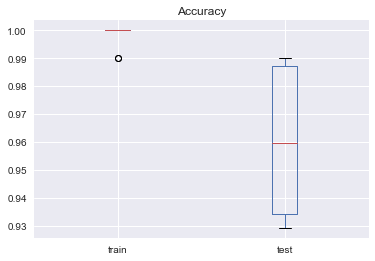

In [31]:
%%time
import lightgbm as lgb

_, direct_kpca_gb = measure_classification_accuracy(
    estimator=lgb.LGBMClassifier(
        n_estimators=100, 
        min_data_in_leaf=5,
        objective='cross_entropy',
        is_unbalance=False,
        num_leaves=5,
        learning_rate=0.02,
    #     monotone_constraints=(1, 1, 1),
    ),
    emb_o=KernelPCA(kernel='precomputed', n_components=10), 
    D_preprocess=lambda x: np.exp(-x), 
    D_train_1_l=D_new_train_list, 
    D_train_2_l=D_new_train_list, 
    D_test_l=D_new_test_list, 
    path_data_train_2_l=path_data_new_train_list, 
    path_data_test_l=path_data_new_test_list,
)

### Simple distance + No embedding + Logistic Regression

accuracy (train) = 0.966
accuracy (test) = 0.933
03    0.71
12    0.18
21    0.08
30    0.03
Wall time: 981 ms


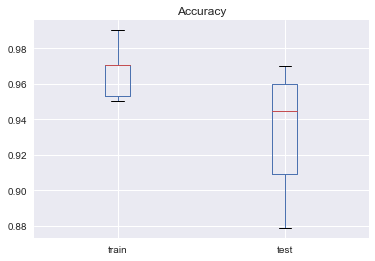

In [32]:
%%time
_, direct_none_lr = measure_classification_accuracy(
    estimator=LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        max_iter=1000,
    ),
    emb_o=None, 
    D_preprocess=None, 
    D_train_1_l=None, 
    D_train_2_l=D_new_train_list, 
    D_test_l=D_new_test_list, 
    path_data_train_2_l=path_data_new_train_list, 
    path_data_test_l=path_data_new_test_list,
)

### Simple distance + No embedding + Gradient Boosting

accuracy (train) = 0.997
accuracy (test) = 0.928
03    0.32
12    0.27
30    0.21
21    0.10
23    0.08
02    0.01
Wall time: 822 ms


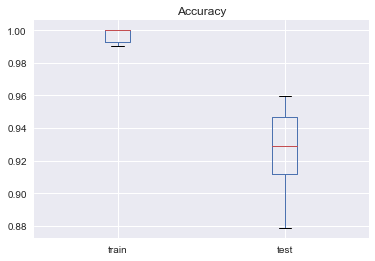

In [33]:
%%time
_, direct_none_gb = measure_classification_accuracy(
    estimator=lgb.LGBMClassifier(
        n_estimators=100, 
        min_data_in_leaf=5,
        objective='cross_entropy',
        is_unbalance=False,
        num_leaves=5,
        learning_rate=0.02,
    #     monotone_constraints=(1, 1, 1),
    ),
    emb_o=None,
    D_preprocess=None, 
    D_train_1_l=None, 
    D_train_2_l=D_new_train_list, 
    D_test_l=D_new_test_list, 
    path_data_train_2_l=path_data_new_train_list, 
    path_data_test_l=path_data_new_test_list,
)

### Simple distance + No embedding + SVM

accuracy (train) = 0.950
accuracy (test) = 0.926
03    0.84
12    0.12
30    0.03
21    0.01
Wall time: 88 ms


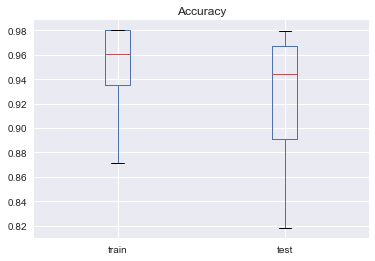

In [34]:
%%time
from sklearn.svm import SVC

_, direct_svm = measure_classification_accuracy(
    estimator=SVC(
        kernel='precomputed',
        max_iter=1000,
    ),
    emb_o=None, 
    D_preprocess=lambda x: np.exp(-x), 
    D_train_1_l=None, 
    D_train_2_l=D_new_train_list, 
    D_test_l=D_new_test_list, 
    path_data_train_2_l=path_data_new_train_list, 
    path_data_test_l=path_data_new_test_list,
)

### "Smart" distance + Kernel PCA + Logistic Regression

accuracy (train) = 0.706
accuracy (test) = 0.636
03    0.57
12    0.21
30    0.14
21    0.08
Wall time: 168 ms


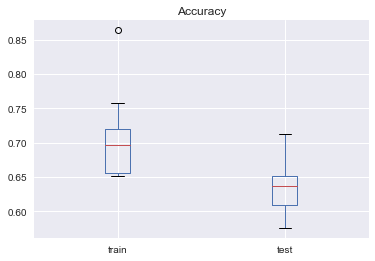

In [35]:
%%time
_, smart_kpca_lr = measure_classification_accuracy(
    estimator=LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        max_iter=1000,
    ),
    emb_o=KernelPCA(kernel='precomputed', n_components=10), 
    D_preprocess=lambda x: np.exp(-x), 
    D_train_1_l=D_new_train_1_sm_list, 
    D_train_2_l=D_new_train_2_sm_list, 
    D_test_l=D_new_test_sm_list, 
    path_data_train_2_l=path_data_new_train_2_sm_list, 
    path_data_test_l=path_data_new_test_sm_list,
)

### "Smart" distance + Kernel PCA + Grading Boosting

accuracy (train) = 0.995
accuracy (test) = 0.879
03    0.49
30    0.31
12    0.11
21    0.04
23    0.04
20    0.01
Wall time: 426 ms


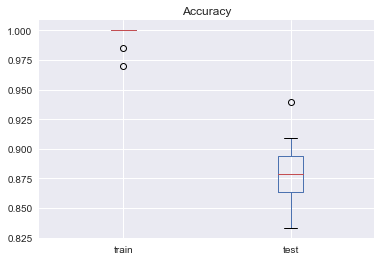

In [36]:
%%time
import lightgbm as lgb

_, smart_kpca_gb = measure_classification_accuracy(
    estimator=lgb.LGBMClassifier(
        n_estimators=100, 
        min_data_in_leaf=5,
        objective='cross_entropy',
        is_unbalance=False,
        num_leaves=5,
        learning_rate=0.02,
    #     monotone_constraints=(1, 1, 1),
    ),
    emb_o=KernelPCA(kernel='precomputed', n_components=10), 
    D_preprocess=lambda x: np.exp(-x), 
    D_train_1_l=D_new_train_1_sm_list, 
    D_train_2_l=D_new_train_2_sm_list, 
    D_test_l=D_new_test_sm_list, 
    path_data_train_2_l=path_data_new_train_2_sm_list, 
    path_data_test_l=path_data_new_test_sm_list,
)

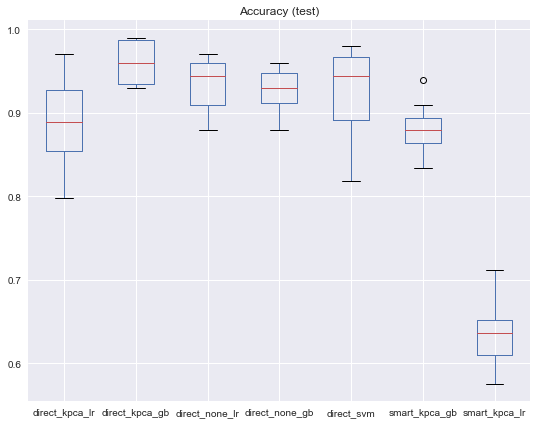

In [45]:
pd.DataFrame(dict(
    direct_kpca_lr=direct_kpca_lr,
    direct_kpca_gb=direct_kpca_gb,
    direct_none_lr=direct_none_lr,
    direct_none_gb=direct_none_gb,
    direct_svm=direct_svm,
    smart_kpca_gb=smart_kpca_gb,
    smart_kpca_lr=smart_kpca_lr,
)).plot(kind='box', title='Accuracy (test)', figsize=(9, 7))

# pd.DataFrame({
#     'KernelPCA+LR': direct_kpca_lr,
#     'KernelPCA+GB': direct_kpca_gb,
#     'LR': direct_none_lr,
#     'GB': direct_none_gb,
#     'SVM': direct_svm,
# }).plot(kind='box', title='Accuracy (test)', figsize=(9, 7))
_ = _

## How did we do?

Here is breakdown of mean model accuracy on the test set:
- Simple distance + Kernel PCA + Logistic Regression: 89%
- Simple distance + Kernel PCA + Grading Boosting: **96%**
- Simple distance + No embedding + Logistic Regression: **93%**
- Simple distance + No embedding + Grading Boosting: **93%**
- Simple distance + No embedding + SVM: **93%**
- Smart distance + Kernel PCA + Logistic Regression: 63%
- Smart distance + Kernel PCA + Grading Boosting: 88%

**Our winner** is Kernel PCA + Grading Boosting with 96% mean accuracy on the test set, closely followed by Logistic Regression and SVM with no embedding. More than 90% accuracy vs. 12.5% accuracy of a completely random classifier, even without hyper-parameter tuning - that's pretty good. Without a clear business context, we can't say for sure that we cracked the case but we probably did.

A few interesting observations:
- Our "smart" distance computation was a failure. Well, it never hurts to try!
- Using an embedding can improve or deteriorate model performance depending on classifier. Robust Logistic Regression benefited the most from having more information from full dissimilarity matrix. A flexible Gradient Boosting model did better with fewer dimensions produced by an embedding.
- Using an embedding decreased model training time. Although, SVM (which does not require an embedding) was the fastest. Of course, in general, training time will depend on data, embedding and classifier.

Why don't we have 100% accuracy? Models usually get confused between the trade posts 0 and 3. There are several trade route pairs that could be confusing for the model:
- 2 -> 0 vs. 2 -> 3
- 1 -> 0 vs. 1 -> 3 (lower) vs. 1 -> 3 (upper)

> Homework. Achieve at least 98% mean accuracy. I'm not certain it is possible... so good luck! Just remember to be one of the good Data Scientists who do NOT overfit their models.

# Use case: Website Categories

Let's consider the following problem: we'd like to guess a category of website - educational, online shop, news, etc. - only by its domain name and front page.

A website page has a tree-like structure, and it can be rather complex. Here is an interesting article on how tree kernels could be useful for this problem: https://www.toptal.com/machine-learning/structured-data-tree-kernels

Now, what if we combine tree kernes with embeddings?

> Homework. Now, this whole use case will be your homework. Scrape some websites and learn how to categorize them. Think, what other problem you could solve knowing a website category? This is a very open-ended exercise. Improvise. Adapt. Overcome!

# Conclusion

We've seen what embeddings are and how they can be used to solve real-world problems. Time for a verdict: to be or not to be?

## Pros
- Combining similarity matrices with embeddings allows us to work with very complex data, which you may not be able to do otherwise.
- The output is low-dimensional numerical data, which you can easily analyze, cluster or use as a model feature.

## Cons
- Using this approach, we will necessarily **lose some information**: 
    - first, when we replace original data with similarity matrix;
    - second, when we reduce dimensionality using an embedding.
- Computation of similarity matrix can be quite slow so we may need enough computational power - or patience.
- Certain embeddings are very sensitive to noise in data so additional data cleaning may be required.

## Alternatives: Why not just use...?
- Why not just use an embedding directly on data, not similarity matrix? If you know an embedding that you can use to efficiently encode your data directly - by all means, use it.
- Why not just use clusterization on similarity matrix? If the only goal is to find clusters in a dataset, it would be totally okay to do so. Some clusterization methods leverage embeddings too - for example, Spectral Clustering.
- Why not just use similarity matrix as features? Unlike similarity matrix with the size $(n_{samples}, n_{samples})$, the output of similarity matrix + embedding will have the size $(n_{samples}, n_{components})$, where $n_{components} << n_{samples}$. The fewer dimensions we have, the easier it is to deal with data.
- Why not just use SVM with similarity matrix? SVM is a great model, which performed well in our Trade Route problem. However, there are three potential caveats:
    - If we'd like to add other features - which could be just simple numerical numbers - we won't be able to do it directly. We'd have to incorporate them in our similarity matrix and potentially lose some valuable information.
    - As good as SVM are, another model may work better for some particular problem.
- Why not just use Deep Learning? It is true: you can solve anything with the right neural network! Keep in mind, the process of finding, training, validating and deploying this neural network will not necessarily be a simple one... So, as always, use your best judgment!

## In one sentence
Embeddings that work on similarity (or dissimilarity) matrices is an incredibly useful tool if you need to work with complex non-numerical data, especially when you cannot transform it into a vector space directly and would prefer to have a low-dimensional input for your model.